This notebook can be run with the binder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Ftwo-way-kernel-matrix-puncturing/master?urlpath=lab/tree/supp_mat_figures.ipynb)

# <center>*"Two-way kernel matrix puncturing: towards resource-efficient PCA and spectral clustering"*</center>
## <center>-- Supplementary Material -- </center>
## <center>-- Python Codes of main article figures --</center>

## Preamble: useful packages and functions

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import scipy.linalg as lin
import scipy.stats as stats
import scipy.sparse.linalg
import scipy.special
import pandas as pd
import seaborn as sns

from numpy.random import default_rng

rng = default_rng(0)

%load_ext autoreload

%autoreload 2

# user's functions from the local .py file
from punctutils import *

%matplotlib inline

plt.rcParams.update({"font.size": 12})

## Two-way puncturing of the kernel matrix

The data matrix is $X\in \mathbb{C}^{p \times n}$ where $p$ and $n$ are the feature and sample size resp.

Then 

$$K = \left[ \frac 1p (X \circ S)' (X \circ S) \right]  \circ B$$

is the $n\times n$ *two-way punctured* kernel matrix where $ \circ$ is the Hadamard (elementwise) product and
 * &nbsp; $S$ is the Bernoulli iid $(p \times n)$ random matrix to select the **data** entries with rate `eS`
 * &nbsp; $B$ is the Bernoulli iid $(n \times n)$ random matrix to select the **kernel** entries with rate `eB`

## Simulations


#### Figure 1.
Eigenvalue distribution $\nu_n$ of $K$ versus limit measure $\nu$, for $p=200$, $n=4\,000$, $x_i\sim .4 \mathcal N(\mu_1,I_p)+.6\mathcal N(\mu_2,I_p)$ for 
$[\mu_1^T,\mu_2^T]^T \sim \mathcal{N}\left(0, \frac1p {\tiny \left[\begin{matrix} 10 & 5.5 \\ 5.5 & 15\end{matrix}\right]}\otimes I_p\right)$; 
$\varepsilon_S=.2$, $\varepsilon_B=.4$. Sample vs theoretical spikes in blue vs red circles. <b>The two "humps" remind the semi-circular and Marcenko-Pastur laws.</b>

In [2]:
# Generation of the mean vectors for each sample

p = 200  # dimension size
n = 4000  # sample size
c0 = p / n  # dimension/sample size ratio

# Set the covariance for the two mean vectorss
cov_mu = np.array([[10, 5.5], [5.5, 15]]) / p
mus = gen_synth_mus(p=p, n=n, cov_mu=cov_mu)

# Set the proportion for each of the two classes
cs = [0.4, 0.6]

# Generate the noisy data matrix and the spikes matrices
X, ells, vM = gen_synth_X(p, n, mus, cs)

# Puncturing settings
eS = 0.2  # data puncturing ratio
eB = 0.4  # kernel puncturing ratio
b = 1  # kernel matrix diagonal entry

#  Empirical Spectrum
lambdas = puncture_eigs(X, eB, eS, b)[0]
xmin = min(np.min(lambdas) * 0.8, np.min(lambdas) * 1.2)  # accounting negative min
xmax = np.max(lambdas) * 1.2
xs, density = lsd(eB, eS, c0, b, xmin=xmin, xmax=xmax, nsamples=200)

isolated_eig_0 = spike(eB, eS, c0, ells[0], b=1)[0]
isolated_eig_1 = spike(eB, eS, c0, ells[1], b=1)[0]

f, ax = plt.subplots(1, 1)
sns.histplot(
    lambdas.flatten(),  # color="blue", cbar_kws={'edgecolor': 'darkblue'},
    stat="density",
    ax=ax,
)
plt.plot(xs, density, "r", label="Limiting density")
plt.plot(
    isolated_eig_0, 0.002, "og", fillstyle="none", label=r"limiting spikes $\rho_{1,2}$"
)
plt.plot(isolated_eig_1, 0.002, "og", fillstyle="none")
plt.plot(lambdas[-1], 0.002, "ob", label=r"Largest eigvals")
plt.plot(lambdas[-2], 0.002, "ob")

plt.legend()
plt.xlim([-2, 5])
_ = plt.show()

#### Figure 2.
Illustration of Theorem 2: asymptotic sample-population eigenvector alignment for $\mathcal L=\ell \in\mathbb R$, as a function of the ``information strength'' $\ell$. Various values of $(\varepsilon_S,\varepsilon_B,c_0)$ indicated in legend. Black dashed lines indicate the limiting (small $\varepsilon_S,\varepsilon_B$) phase transition threshold $\Gamma=(\varepsilon_S^2\varepsilon_Bc_0^{-1})^{-\frac12}$. <b>As $\varepsilon_S,\varepsilon_B\to 0$, performance curves coincide when $\varepsilon_B\varepsilon_S^2c_0^{-1}$ is constant (plain versus dashed set of curves).</b>

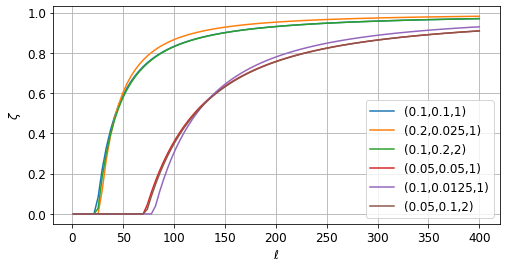

In [3]:
eSeBc0s = [
    (0.1, 0.1, 1),
    (0.2, 0.025, 1),
    (0.1, 0.2, 2),
    (0.05, 0.05, 1),
    (0.1, 0.0125, 1),
    (0.05, 0.1, 2),
]
ells = np.linspace(1, 400, 100)
plt.figure(figsize=(8, 4))
for eS, eB, c0 in eSeBc0s:
    plt.plot(
        ells,
        [spike(eB, eS, c0, ell)[1] for ell in ells],
        label="({},{},{})".format(eS, eB, c0),
    )
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\zeta$")
plt.grid("On")
_ = plt.legend()

#### Figure 3.

Phase transition curves $F(\ell)=0$ for $\mathcal L=\ell\in\mathbb R$ and varying values of $\ell$, for $c_0=.05$. Above each phase transition curve, a spike eigenvalue is found away from the support of $\nu$. <b>For large $\ell$, a wide range of $\varepsilon_B$'s (resp., $\varepsilon_S$) is admissible at virtually no performance loss. Here, also, sparser $B$ matrices are more effective than sparser $S$ matrices.</b>

In [4]:
ells = [1, 2, 5]  # spike powers
c0 = 0.05

f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ell in ells:
    eBs, eSs = phase_transition(c0, ell, res=1e-3)
    ax[0].axes.plot(eBs, eSs, label=r"$\ell$={}".format(ell))
    ax[1].axes.plot(eSs, eBs, label=r"$\ell$={}".format(ell))

ax[0].axes.set_xlabel(r"$\varepsilon_B$")
ax[0].axes.set_ylabel(r"$\varepsilon_S$")
ax[0].axes.grid("On")
ax[1].axes.set_xlabel(r"$\varepsilon_S$")
ax[1].axes.set_ylabel(r"$\varepsilon_B$")
ax[1].axes.set_ylim([0, 0.3])
ax[1].axes.grid("On")
ax[1].axes.legend()
_ = plt.show()

#### Figure 4: 
Two-way punctured matrices $K$ for **(left)** $(\varepsilon_S,\varepsilon_B)=(.2,1)$ or **(right)** $(\varepsilon_S,\varepsilon_B)=(1,.04)$, with $c_0=\frac12$, $n=4\,000$, $p=2\,000$, $b=0$. Clustering setting with $x_i\sim .4\mathcal N(\mu_1,I_p)+.6\mathcal N(\mu_2,I_p)$ for $[\mu_1^T,\mu_2^T]^T\sim \mathcal N(0, \frac1p[ {\tiny \begin{matrix} 20 & 12 \\ 12 & 30\end{matrix}}]\otimes I_p)$. **(Top)** first $100\times 100$ absolute entries of $K$ (white for zero); **(Middle)** spectrum of $K$, theoretical limit, and isolated eigenvalues; **(Bottom)** second dominant eigenvector $\hat v_2$ of $K$ against theoretical average in red. **As confirmed by theory, although (top) $K$ is dense for $\varepsilon_B=1$ and sparse for $\varepsilon_B=.04$ ($96\%$ empty) and (middle) the spectra strikingly differ, (bottom) since $\varepsilon_S^2\varepsilon_Bc_0^{-1}$ is constant, the eigenvector alignment $|\hat v_2^T v_2|^2$ is the same in both cases.**

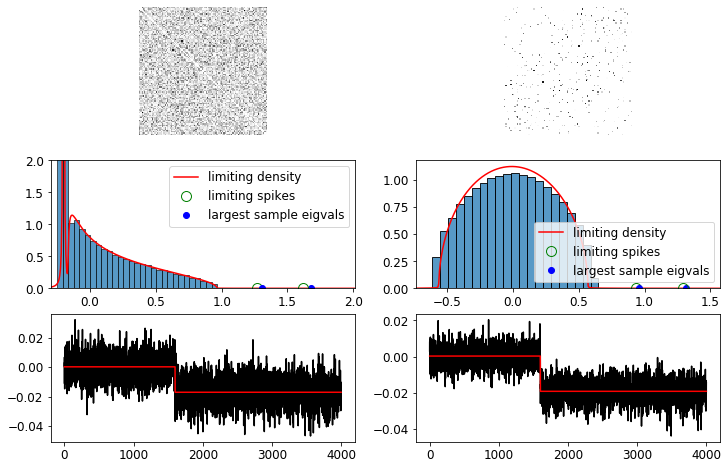

In [5]:
# Generation of the mean vectors for each sample

p = 2000  # dimension size
n = 4000  # sample size
c0 = p / n  # dimension/sample size ratio

# Set the covariance for the two mean vectorss
cov_mu = np.array([[20, 12], [12, 30]]) / p
mus = gen_synth_mus(p=p, n=n, cov_mu=cov_mu)

# Set the proportion for each of the two classes
cs = [0.4, 0.6]
n0 = int(n * cs[0])

# Generate the noisy data matrix and the spikes matrices
X, ells, vM = gen_synth_X(p, n, mus, cs)

# Puncturing settings
eS = 0.2  # data puncturing ratio
eB = 0.04  # kernel puncturing ratio
b = 0  # kernel matrix diagonal entry

f, ax = plt.subplots(3, 2, figsize=(12, 8))

# S-punctured spectrum
B, _, _ = mask_B(n, 1, is_diag=b)  # mask for diag entries
X_S = puncture_X(X, eS)  # punctured data mat
K_S = puncture_K_vanilla(X_S, B)  # remove diag entries
l, u_S = sp.sparse.linalg.eigsh(K_S, k=2, which="LA", tol=0, return_eigenvectors=True)
u_S = u_S[:, 1].ravel()  #  second principal eigvect
u_S = u_S * np.sign(u_S[:n0].mean() - u_S[n0:].mean())
lambdas_S = np.linalg.eigvalsh(K_S.todense())

#  B-punctured spectrum
B, _, _ = mask_B(n, eB, is_diag=b)
K_B = puncture_K_vanilla(X, B)  #  punctured kernel mat
l, u_B = sp.sparse.linalg.eigsh(K_B, k=2, which="LA", tol=0, return_eigenvectors=True)
u_B = u_B[:, 1].ravel()  # second principal eigvect
u_B = u_B * np.sign(u_B[:n0].mean() - u_B[n0:].mean())
lambdas_B = np.linalg.eigvalsh(K_B.todense())


# S-punctured figs

ax[0, 0].imshow(
    np.abs(K_S[:100, :100].todense()), interpolation="nearest", cmap="gray_r"
)
ax[0, 0].axis("off")
disp_eigs(ax[1:, 0], lambdas_S, u_S, 1, eS, c0, n0, ells, b, vM)
ax[1, 0].axes.set_ylim([0, 2])

# B-punctured figs

ax[0, 1].imshow(
    np.abs(K_B[:100, :100].todense()), interpolation="nearest", cmap="gray_r"
)
ax[0, 1].axis("off")
disp_eigs(ax[1:, 1], lambdas_B, u_B, eB, 1, c0, n0, ells, b, vM)

#### Figure 5.

Limiting probability of error of spectral clustering of $\mathcal N(\pm\mu,I_p)$ with equal class sizes on $K$: as a function of $\varepsilon_B$ for fixed $\ell=\|\mu\|^2=50$ <b>(top)</b>, and $\varepsilon_S$ for fixed $\ell=50$ <b>(bottom)</b>. Simulations (single realization) in markers for $p=n=4\,000$ ($\color{blue}\times$) and $p=n=8\,000$ ($\color{blue}+$). <b> Very good fit between theory and practice for not too small $\varepsilon_S,\varepsilon_B$ </b>.

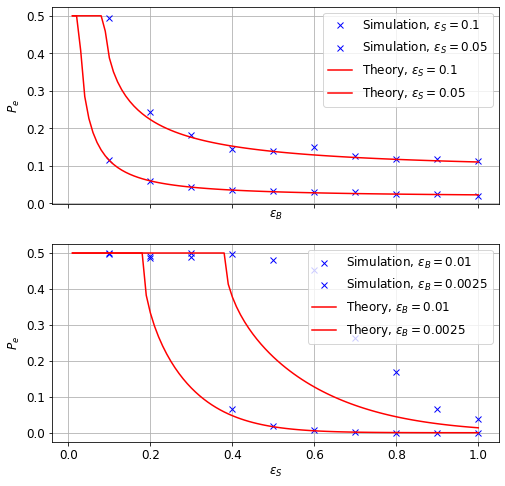

In [6]:
p = 4000

ns = np.array([2000, 2000])
n0 = ns[0]
n = np.sum(ns)
cs = ns / n

c0 = p / n

power = 50
mu = rng.normal(size=(p,))
mu = mu / np.linalg.norm(mu) * np.sqrt(power)
mus = np.array([mu, -mu]).T

X, ells, _ = gen_synth_X(p, n, mus, cs)
ell = np.max(ells)

f, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

## Perf vs epsilon_B (fixed epsilon_S)

res = 1e-1
eSs = [1 / 10, 1 / 20]
eBs = np.linspace(res, 1, int(1 / res))

res_thin = 1e-2
eSs_thin = [1 / 10, 1 / 20]
eBs_thin = np.linspace(res_thin, 1, int(1 / res_thin))

perf_sim = np.zeros((len(eBs), len(eSs)))
perf_th = np.zeros((len(eBs_thin), len(eSs_thin)))

for iS, eS in enumerate(eSs):
    for iB, eB in enumerate(eBs):
        u = puncture_eigs(X, eB, eS, b=1, sparsity=1)[1]
        overlap = 1 / n * (np.sum(u[:n0] > 0) + np.sum(u[n0:] < 0))
        perf_sim[iB, iS] = np.min([overlap, 1 - overlap])

    ax[0].axes.plot(
        eBs, perf_sim[:, iS], "xb", label=r"Simulation, $\varepsilon_S=${}".format(eS)
    )

for iS, eS in enumerate(eSs_thin):
    for iB, eB in enumerate(eBs_thin):
        zeta = spike(eB, eS, c0, ell, b=1)[1]
        perf_th[iB, iS] = qfunc(np.sqrt(zeta / (1 - zeta)))

    ax[0].axes.plot(
        eBs_thin, perf_th[:, iS], "r", label=r"Theory, $\varepsilon_S=${}".format(eS)
    )

ax[0].axes.set_xlabel(r"$\varepsilon_B$")
ax[0].axes.set_ylabel(r"$P_e$")
ax[0].axes.grid("On")
ax[0].axes.legend()


## Perf vs epsilon_S (fixed epsilon_B)

eBs = [1 / 100, 1 / 400]
eSs = np.linspace(res, 1, int(1 / res))

res_thin = 1e-2
eBs_thin = [1 / 100, 1 / 400]
eSs_thin = np.linspace(res_thin, 1, int(1 / res_thin))

perf_sim = np.zeros((len(eSs), len(eBs)))
perf_th = np.zeros((len(eSs_thin), len(eBs_thin)))

for iB, eB in enumerate(eBs):
    for iS, eS in enumerate(eSs):
        u = puncture_eigs(X, eB, eS, b=1, sparsity=1)[1]
        overlap = 1 / n * (np.sum(u[:n0] > 0) + np.sum(u[n0:] < 0))
        perf_sim[iS, iB] = np.min([overlap, 1 - overlap])

    ax[1].axes.plot(
        eSs, perf_sim[:, iB], "xb", label=r"Simulation, $\varepsilon_B=${}".format(eB)
    )

for iB, eB in enumerate(eBs_thin):
    for iS, eS in enumerate(eSs_thin):
        zeta = spike(eB, eS, c0, ell, b=1)[1]
        perf_th[iS, iB] = qfunc(np.sqrt(zeta / (1 - zeta)))

    ax[1].axes.plot(
        eSs_thin, perf_th[:, iB], "r", label=r"Theory, $\varepsilon_B=${}".format(eB)
    )


ax[1].axes.set_xlabel(r"$\varepsilon_S$")
ax[1].axes.set_ylabel(r"$P_e$")
ax[1].axes.grid("On")
ax[1].axes.legend()

**Note:** the GAN data we generated and used in the submitted paper are quite vomuminous. As an alternative to reduce the computational burden, we are using first the smaller, publicly available, MNIST-fashion real-word dataset. However **the conclusions obtained for this smaller real-word dataset are very similar to those drawn in the paper for the GAN data.**

#### Figure 6 (MNIST)

Examples of **MNIST-fashion images**, `trouser` instances **(top row)**, `pullover` instances **(bottom row)**.



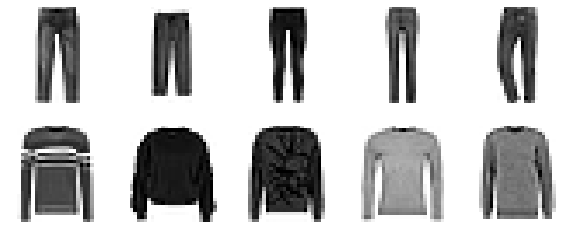

In [7]:
from tensorflow.keras.datasets import fashion_mnist

(X, y), _ = fashion_mnist.load_data()
selected_labels = [1, 2]
nb_im = 5  # number of images to display for each class
im0 = X[y == selected_labels[0]]
im1 = X[y == selected_labels[1]]
f, ax = plt.subplots(2, nb_im, figsize=(10, 4), sharex=True, sharey=True)
for i in range(nb_im):
    ax[0, i].axes.imshow(im0[i, :, :].squeeze(), interpolation="nearest", cmap="gray_r")
    ax[0, i].axes.axis("off")
    ax[1, i].axes.imshow(im1[i, :, :].squeeze(), interpolation="nearest", cmap="gray_r")
    ax[1, i].axes.axis("off")

#### Figure 7 (MNIST)
Empirical classification errors for $2$-class (balanced) MNIST-fashion images (`trouser` vs `pullover`), with $n=512$ (**top**) and $n=2048$ (**bottom**). **Theoretically predicted ``plateau''-behavior observed for all $\varepsilon_B$ not too small**. 

In [8]:
nbMC = 40
df_1, _ = get_perf_clustering(n0=256, nbMC=nbMC)
df_2, _ = get_perf_clustering(n0=1024, nbMC=nbMC)

[progression 40/40]

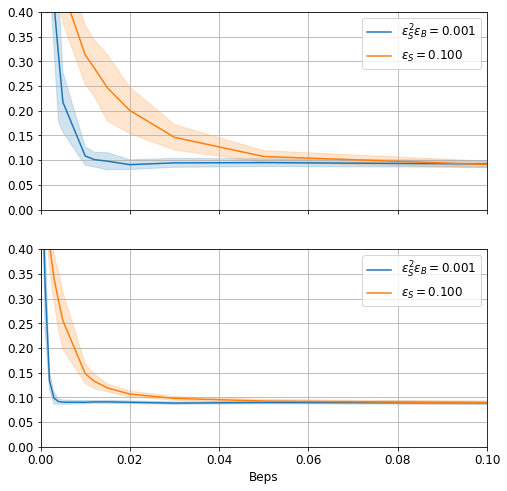

In [9]:
f, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_perf_clustering(df_1, ax[0])
plot_perf_clustering(df_2, ax[1])

#### Figure 8 (MNIST)

Sample vs limiting spectra and dominant eigenvector of $K$ for 2-class MNIST-fashion images (`trouser` vs `pullover`); **(left)** $\varepsilon_S=\varepsilon_B=1$ (error rate: $\mathbb P_e=.09$); **(right)** $\varepsilon_S=0.02$, $\varepsilon_B=0.2$ ($\mathbb P_e=.12$). **Surprisingly good fit between sample and predicted isolated eigenvalue/eigenvector in all cases; as for spectral measure, significant prediction improvement as $\varepsilon_S,\varepsilon_B\to 0$**

Punctured (right) error rate == 0.12
Full (left) error rate == 0.09
Full (left): ratio of *spurrious* eigenvalues > 15 == 14/4096
Full case: largest sample eigval == 980.03, lagest limiting spike == 783.62


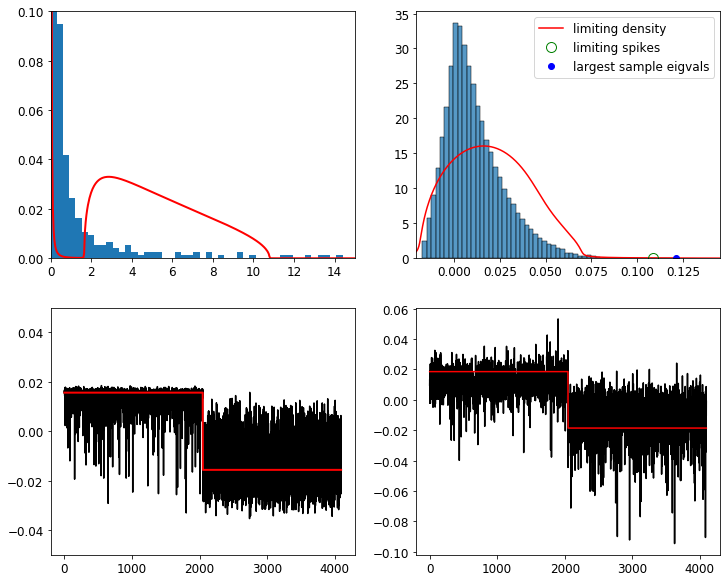

In [10]:
eB = 0.2
eS = 0.02

X, n0, n1, ell = gen_MNIST_vectors(n0=2048)

(p, n) = X.shape
c0 = p / n
eigvals_punct = puncture_eigs(X, eB, eS, b=1, sparsity=0)[0]
u_punct = puncture_eigs(X, eB, eS, b=1, sparsity=1)[1]
u_punct = np.sign(u_punct[:n0].mean() - u_punct[n0:].mean()) * u_punct
overlap = 1 / n * (np.sum(u_punct[:n0] > 0) + np.sum(u_punct[n0:] < 0))
print("Punctured (right) error rate == {:.2f}".format(1 - overlap))

eigvals_full = puncture_eigs(X, eB=1, eS=1, b=1, sparsity=0)[0]
u_full = puncture_eigs(X, eB=1, eS=1, b=1, sparsity=1)[1]
u_full = np.sign(u_full[:n0].mean() - u_full[n0:].mean()) * u_full
overlap = 1 / n * (np.sum(u_full[:n0] > 0) + np.sum(u_full[n0:] < 0))
print("Full (left) error rate == {:.2f}".format(1 - overlap))

# Full: truncate the eigvals dist to show the histogram
lmax = 15
# Count the largest 'spurious' eigenvalues
print(
    "Full (left): ratio of *spurious* eigenvalues > {:d} == {:d}/{:d}".format(
        lmax, np.sum(eigvals_full > lmax), n
    )
)

f, axes = plt.subplots(2, 2, figsize=(12, 10))
# Puncturing
disp_eigs(axes[:, 1], eigvals_punct, u_punct, eB, eS, c0, n0, ell, b=1, vM=None)
# Full
disp_eigs_full(axes[:, 0], eigvals_full, u_full, c0, ell, lmax=lmax, b=1)

plt.show()

#### Figure 6 (GAN)

Examples of **BigGAN-generated images**, `collie` dog instances (top row), `tabby` cat instances (bottom row).

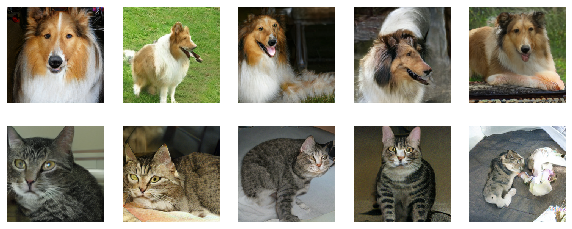

In [11]:
from pathlib import Path
from PIL import Image

basename = Path("./data")  #  relative path to data folder in the gitlab repo
nb_im = 5  # number of images to display for each class
f, ax = plt.subplots(2, nb_im, figsize=(10, 4), sharex=True, sharey=True)
for i in range(nb_im):
    incollie = "collie_" + str(i) + ".png"
    im = Image.open(basename / incollie)
    ax[0, i].axes.imshow(im)
    ax[0, i].axes.axis("off")
    intabby = "tabby_" + str(i) + ".png"
    im = Image.open(basename / intabby)
    ax[1, i].axes.imshow(im)
    ax[1, i].axes.axis("off")

#### Figure 7 (GAN)
Empirical classification errors for $2$-class (balanced) BigGAN-generated images (`tabby` vs `collie`), with $n=2500$ (**top**) and $n=1000$ (**bottom**). **Theoretically predicted ``plateau''-behavior observed for all $\varepsilon_B$ not too small**. 

In [12]:
nbMC = 10  #  number of runs (not too large to reduce the computational burden...)
df_gan_1, _ = get_perf_clustering(n0=1250, nbMC=nbMC, isGAN=True)
df_gan_2, _ = get_perf_clustering(n0=5000, nbMC=nbMC, isGAN=True)

[progression 10/10]

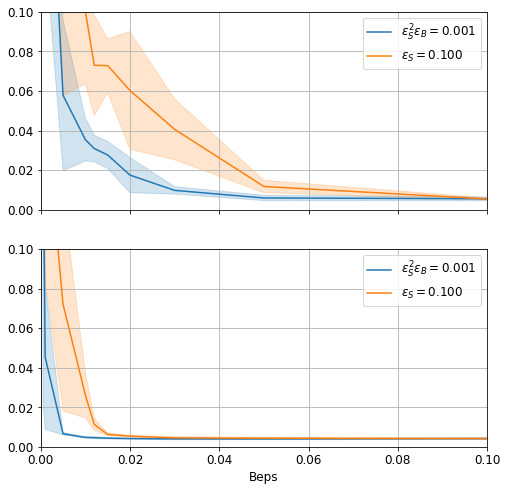

In [13]:
f, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_perf_clustering(df_gan_1, ax[0], isGAN=True)
plot_perf_clustering(df_gan_2, ax[1], isGAN=True)

#### Figure 8 (GAN)

Sample vs limiting spectra and dominant eigenvector of $K$ for 2-class GAN images (`tabby` vs `collie`); **(left)** $\varepsilon_S=\varepsilon_B=1$ (error rate: $\mathbb P_e=.004$); **(right)** $\varepsilon_S=0.01$, $\varepsilon_B=0.2$ ($\mathbb P_e=.011$). **Surprisingly good fit between sample and predicted isolated eigenvalue/eigenvector in all cases; as for spectral measure, significant prediction improvement as $\varepsilon_S,\varepsilon_B\to 0$**

In [16]:
eB = 0.2
eS = 0.01

X, n0, n1, ell = gen_GAN_vectors(n0=5000)

(p, n) = X.shape
c0 = p / n
eigvals_punct = puncture_eigs(X, eB, eS, b=1, sparsity=0)[0]
u_punct = puncture_eigs(X, eB, eS, b=1, sparsity=1)[1]
u_punct = np.sign(u_punct[:n0].mean() - u_punct[n0:].mean()) * u_punct
overlap_punct = 1 / n * (np.sum(u_punct[:n0] > 0) + np.sum(u_punct[n0:] < 0))

eigvals_full = puncture_eigs(X, eB=1, eS=1, b=1, sparsity=0)[0]
u_full = puncture_eigs(X, eB=1, eS=1, b=1, sparsity=1)[1]
u_full = np.sign(u_full[:n0].mean() - u_full[n0:].mean()) * u_full
overlap_full = 1 / n * (np.sum(u_full[:n0] > 0) + np.sum(u_full[n0:] < 0))

Punctured (right) error rate == 0.011
Full (left) error rate == 0.004
Full (left): ratio of *spurious* eigenvalues > 30 == 38/10000
Full case: largest sample eigval == 3678.38, lagest limiting spike == 3342.33


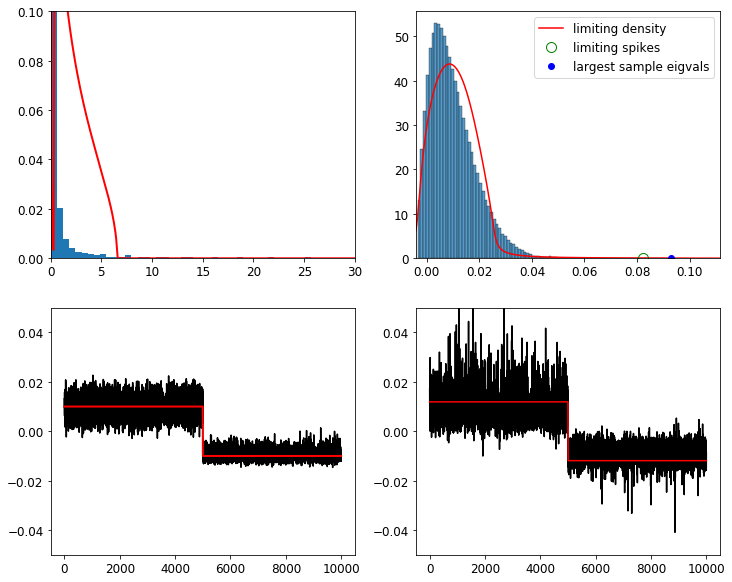

In [17]:
print("Punctured (right) error rate == {:.3f}".format(1 - overlap_punct))
print("Full (left) error rate == {:.3f}".format(1 - overlap_full))

# Full: truncate the eigvals dist to show the histogram
lmax = 30
# Count the largest 'spurious' eigenvalues
print(
    "Full (left): ratio of *spurious* eigenvalues > {:d} == {:d}/{:d}".format(
        lmax, np.sum(eigvals_full > lmax), n
    )
)

f, axes = plt.subplots(2, 2, figsize=(12, 10))
# Puncturing
disp_eigs(axes[:, 1], eigvals_punct, u_punct, eB, eS, c0, n0, ell, b=1, vM=None)
axes[1, 1].axes.set_ylim([-0.05, 0.05])
#  Full
disp_eigs_full(axes[:, 0], eigvals_full, u_full, c0, ell, lmax=lmax, b=1)

plt.show()